In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

In [ ]:
def concentric_circles(samples, center=[0.0, 0.0],
                       r_inner=0.4, r_outer=0.8):
    """
    Binary classification: points in a ring are labeled 1
    """

    Xvals, yvals = [], []

    for _ in range(samples):
        x = 2 * np.random.rand(2) - 1
        dist = np.linalg.norm(x - center)

        y = 1 if r_inner < dist < r_outer else 0
        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


In [ ]:
def xor(samples):
    """
    XOR classification on 2D plane
    """

    Xvals, yvals = [], []

    for _ in range(samples):
        x = 2 * np.random.rand(2) - 1
        y = int((x[0] > 0) ^ (x[1] > 0))
        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


In [ ]:
def gaussian_blobs(samples, mean_shift=0.6):
    """
    Two Gaussian clusters
    """

    Xvals, yvals = [], []

    for _ in range(samples):
        if np.random.rand() < 0.5:
            x = np.random.randn(2) * 0.25 + np.array([-mean_shift, 0])
            y = 0
        else:
            x = np.random.randn(2) * 0.25 + np.array([mean_shift, 0])
            y = 1

        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


In [ ]:
def spiral(samples, noise=0.05):
    """
    Two-class spiral dataset
    """

    Xvals, yvals = [], []
    samples_per_class = samples // 2

    for label in [0, 1]:
        for i in range(samples_per_class):
            r = i / samples_per_class
            theta = 4 * np.pi * r + (np.pi if label else 0)
            x = np.array([
                r * np.cos(theta),
                r * np.sin(theta)
            ]) + noise * np.random.randn(2)

            Xvals.append(x)
            yvals.append(label)

    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


In [ ]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [ ]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [ ]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = xor(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = xor(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 15
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    plot_data(X_test, initial_predictions, fig, axes[0])
    plot_data(X_test, predicted_test, fig, axes[1])
    plot_data(X_test, y_test, fig, axes[2])
    axes[0].set_title("Predictions with random weights")
    axes[1].set_title("Predictions after training")
    axes[2].set_title("True test data")
    plt.tight_layout()
    plt.show()

Epoch:  0 | Cost: 0.498908 | Train accuracy: 0.415000 | Test Accuracy: 0.437000
Epoch:  1 | Loss: 0.073160 | Train accuracy: 0.910000 | Test accuracy: 0.953500


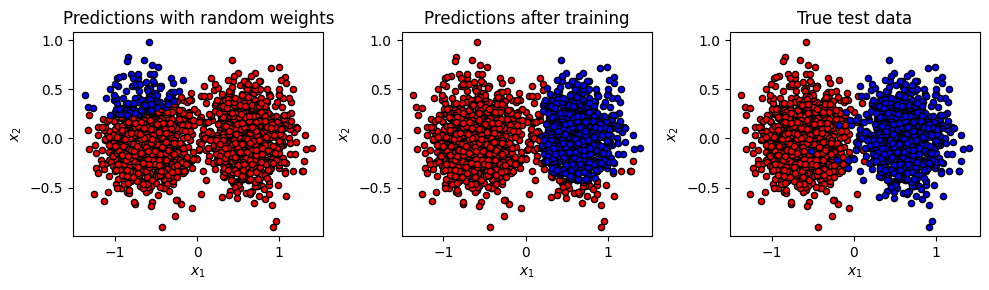

Epoch:  2 | Loss: 0.077040 | Train accuracy: 0.935000 | Test accuracy: 0.926500


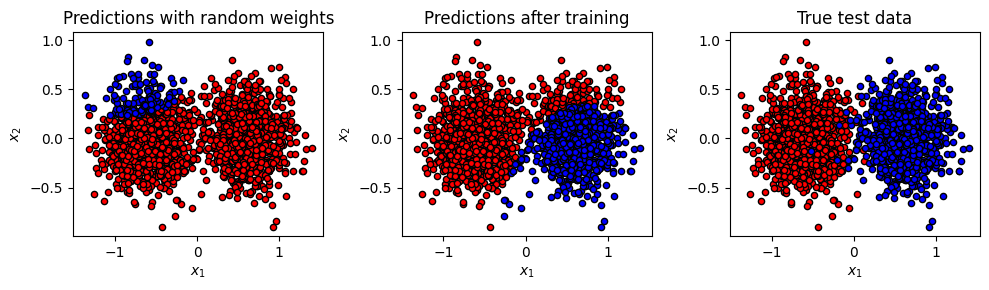

Epoch:  3 | Loss: 0.041421 | Train accuracy: 0.965000 | Test accuracy: 0.969500


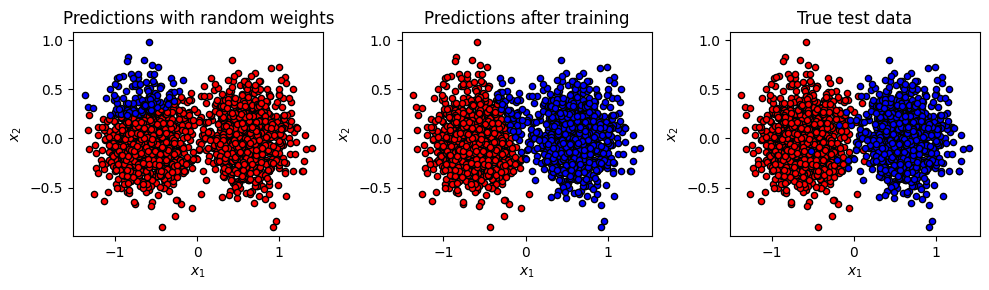

Epoch:  4 | Loss: 0.048944 | Train accuracy: 0.950000 | Test accuracy: 0.939000


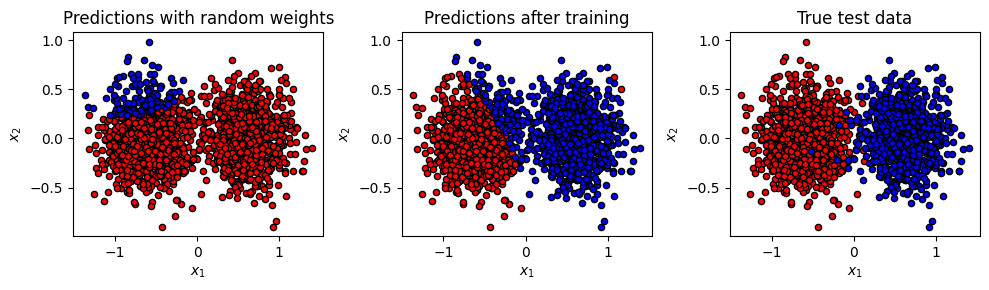

Epoch:  5 | Loss: 0.053819 | Train accuracy: 0.950000 | Test accuracy: 0.944500


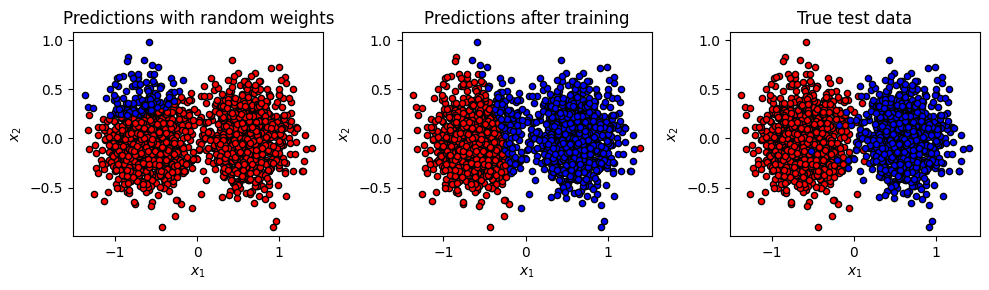

Epoch:  6 | Loss: 0.035987 | Train accuracy: 0.970000 | Test accuracy: 0.972500


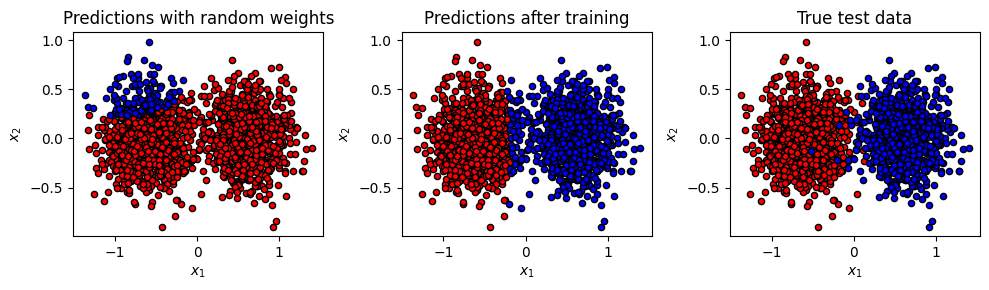

Epoch:  7 | Loss: 0.026416 | Train accuracy: 0.990000 | Test accuracy: 0.987000


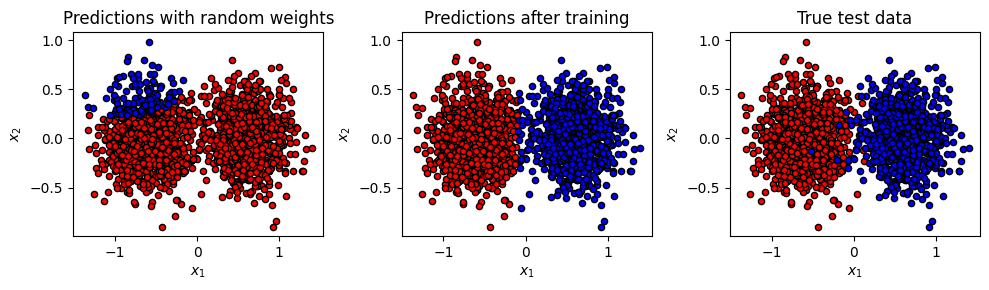

Epoch:  8 | Loss: 0.025492 | Train accuracy: 0.990000 | Test accuracy: 0.990500


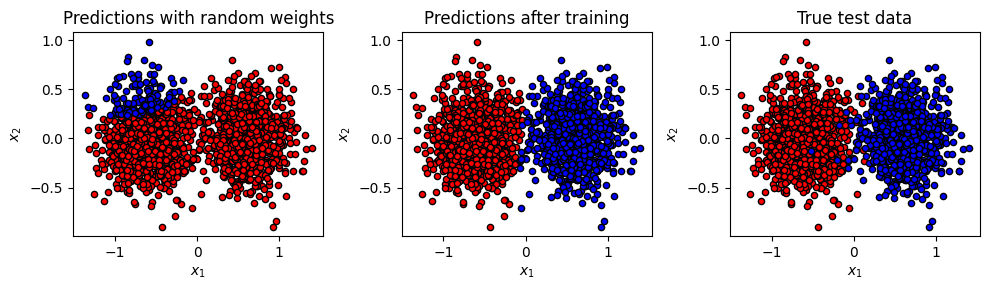

Epoch:  9 | Loss: 0.027018 | Train accuracy: 0.980000 | Test accuracy: 0.983500


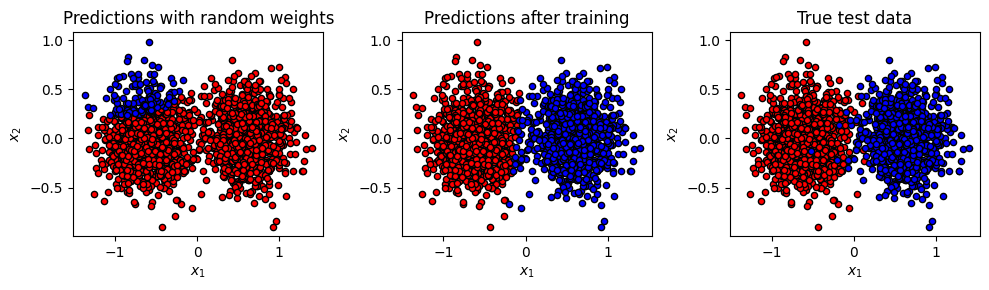

Epoch: 10 | Loss: 0.031520 | Train accuracy: 0.975000 | Test accuracy: 0.976500


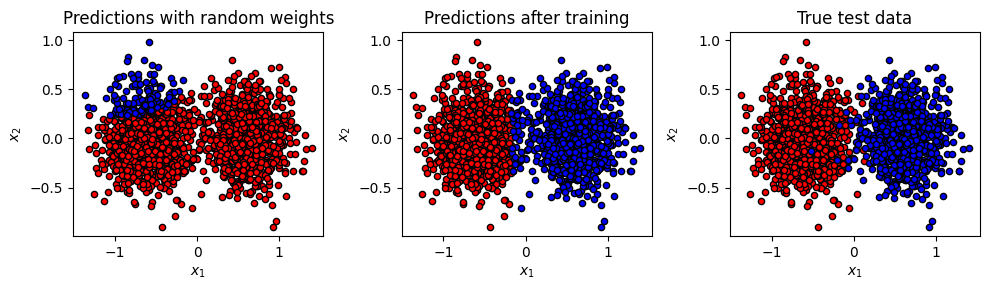

Epoch: 11 | Loss: 0.034333 | Train accuracy: 0.970000 | Test accuracy: 0.972000


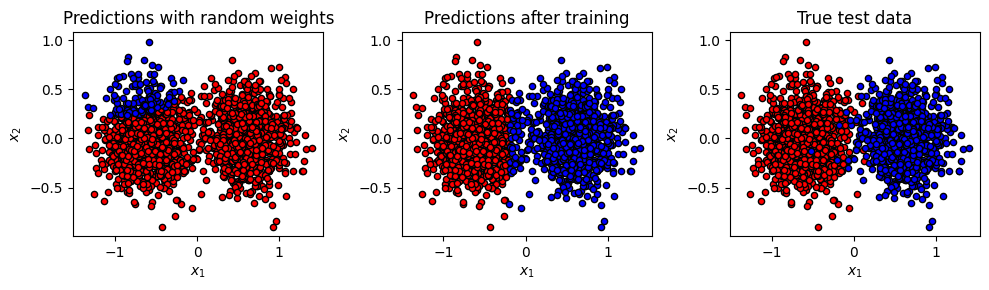

Epoch: 12 | Loss: 0.034896 | Train accuracy: 0.975000 | Test accuracy: 0.971000


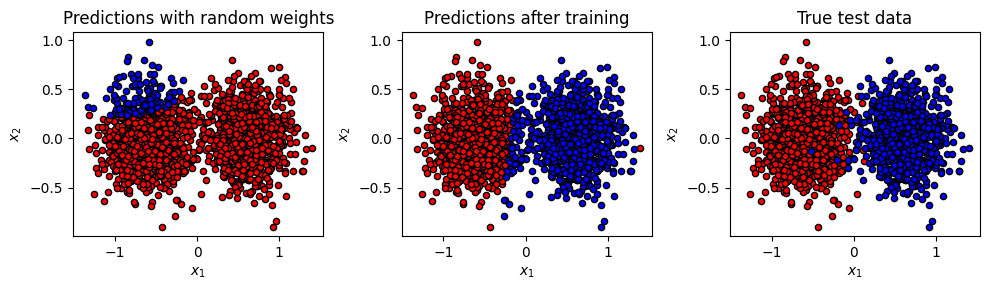

Epoch: 13 | Loss: 0.034078 | Train accuracy: 0.980000 | Test accuracy: 0.971000


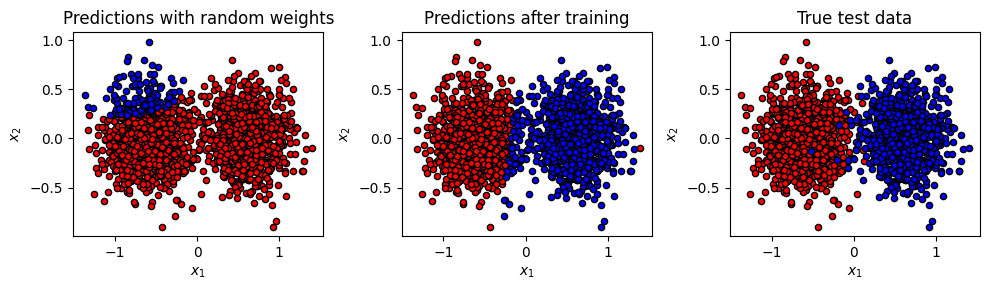

Epoch: 14 | Loss: 0.033311 | Train accuracy: 0.975000 | Test accuracy: 0.974000


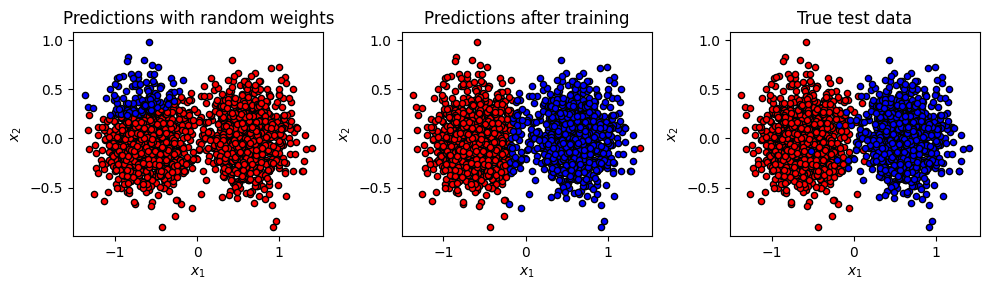

Epoch: 15 | Loss: 0.033388 | Train accuracy: 0.975000 | Test accuracy: 0.974000


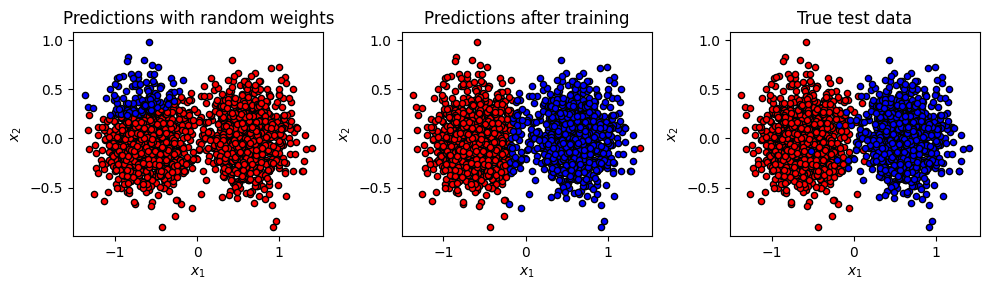

In [ ]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = gaussian_blobs(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = gaussian_blobs(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 15
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    plot_data(X_test, initial_predictions, fig, axes[0])
    plot_data(X_test, predicted_test, fig, axes[1])
    plot_data(X_test, y_test, fig, axes[2])
    axes[0].set_title("Predictions with random weights")
    axes[1].set_title("Predictions after training")
    axes[2].set_title("True test data")
    plt.tight_layout()
    plt.show()

Epoch:  0 | Cost: 0.311646 | Train accuracy: 0.505000 | Test Accuracy: 0.504000
Epoch:  1 | Loss: 0.303382 | Train accuracy: 0.480000 | Test accuracy: 0.488000


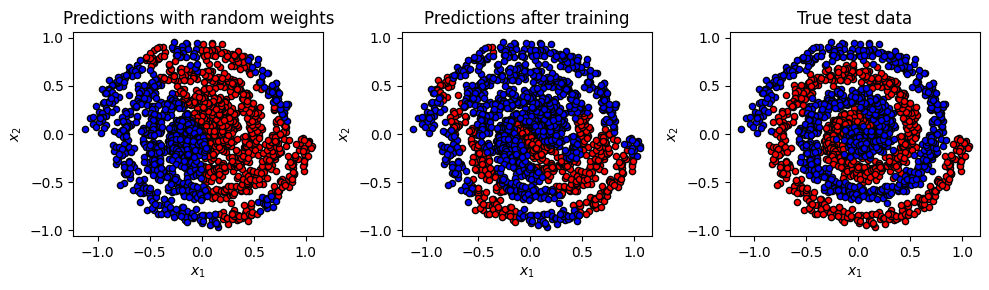

Epoch:  2 | Loss: 0.336710 | Train accuracy: 0.500000 | Test accuracy: 0.519500


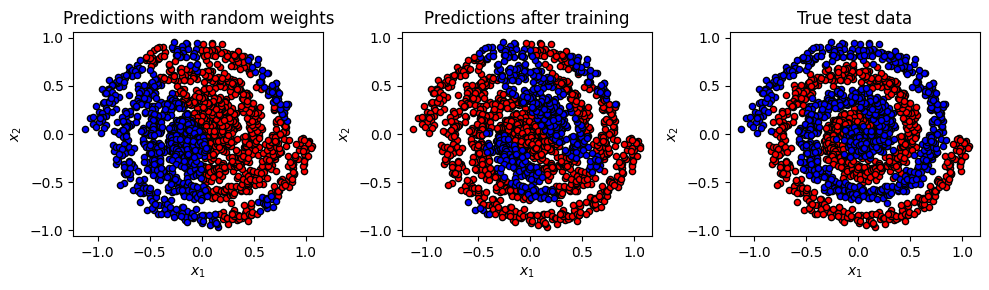

Epoch:  3 | Loss: 0.319326 | Train accuracy: 0.495000 | Test accuracy: 0.512500


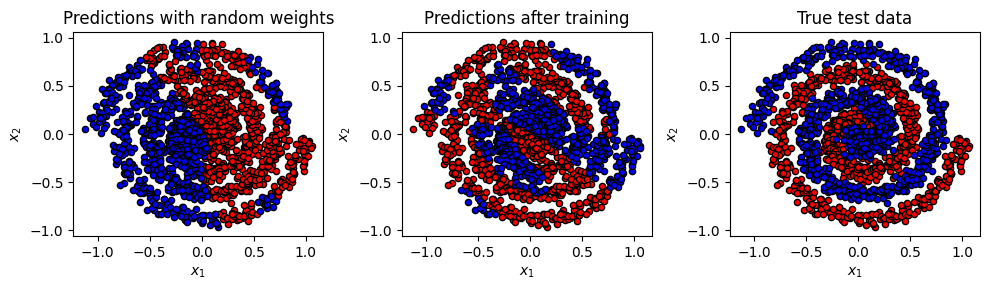

Epoch:  4 | Loss: 0.329880 | Train accuracy: 0.530000 | Test accuracy: 0.545000


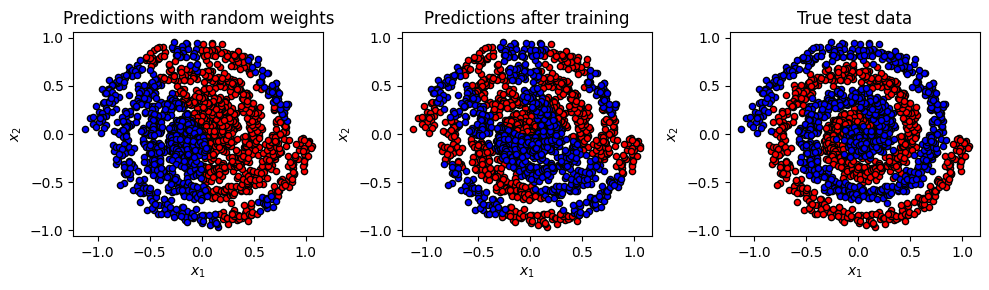

Epoch:  5 | Loss: 0.300567 | Train accuracy: 0.530000 | Test accuracy: 0.522000


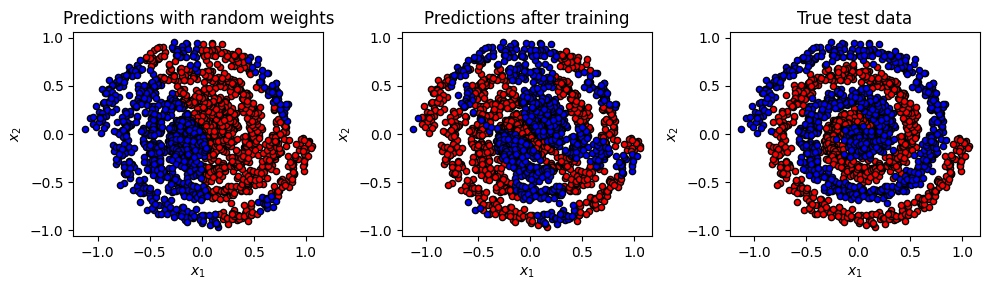

Epoch:  6 | Loss: 0.317162 | Train accuracy: 0.580000 | Test accuracy: 0.549000


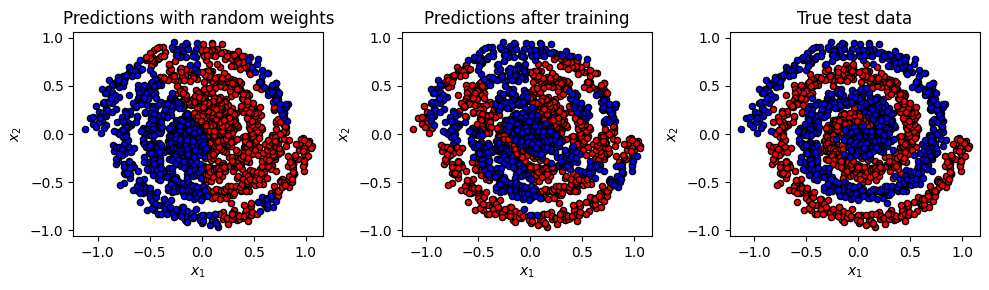

Epoch:  7 | Loss: 0.279265 | Train accuracy: 0.595000 | Test accuracy: 0.575500


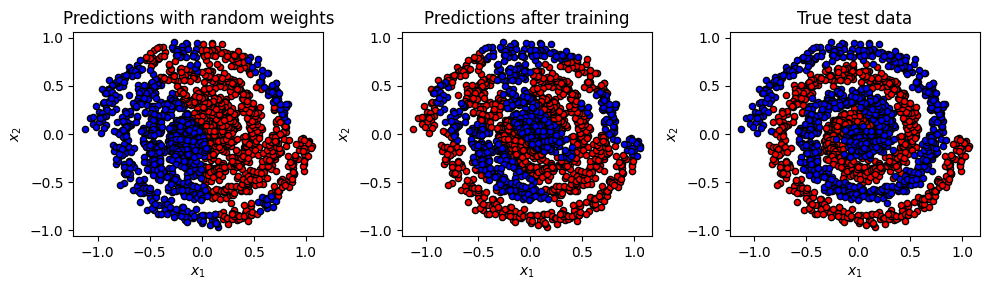

Epoch:  8 | Loss: 0.271982 | Train accuracy: 0.575000 | Test accuracy: 0.551000


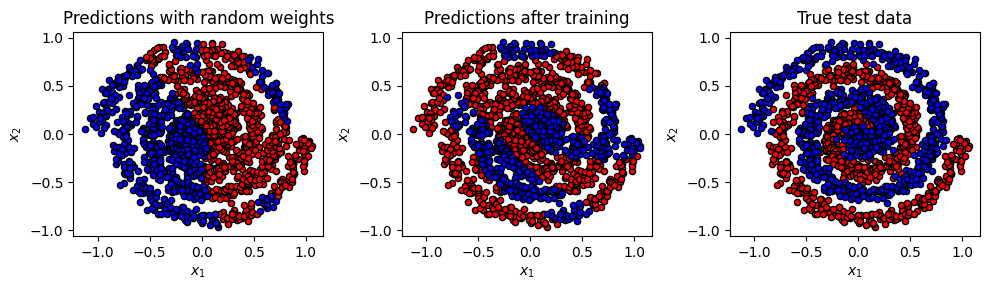

Epoch:  9 | Loss: 0.298906 | Train accuracy: 0.550000 | Test accuracy: 0.561000


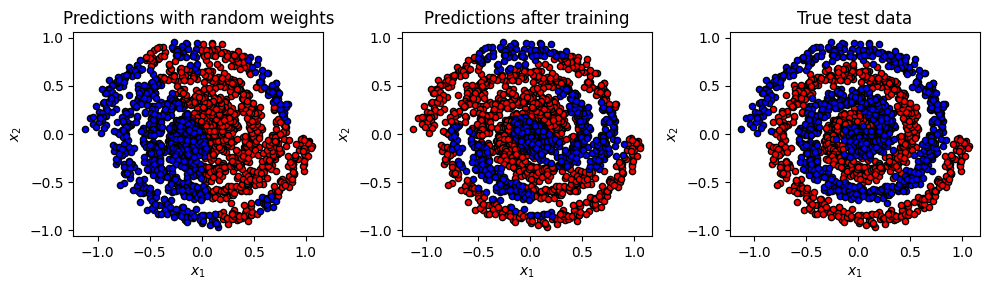

Epoch: 10 | Loss: 0.219326 | Train accuracy: 0.645000 | Test accuracy: 0.646000


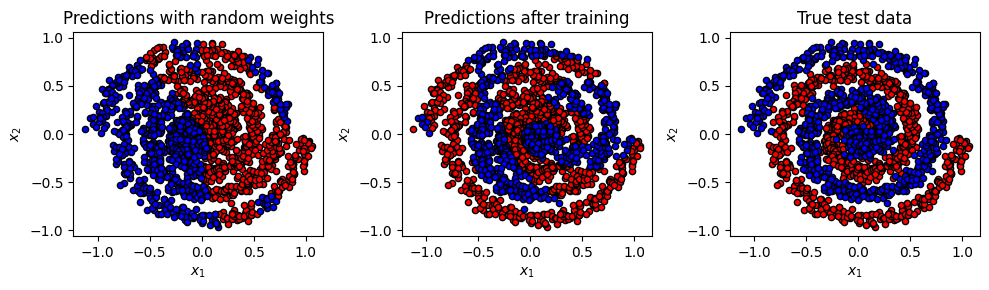

Epoch: 11 | Loss: 0.199035 | Train accuracy: 0.690000 | Test accuracy: 0.673500


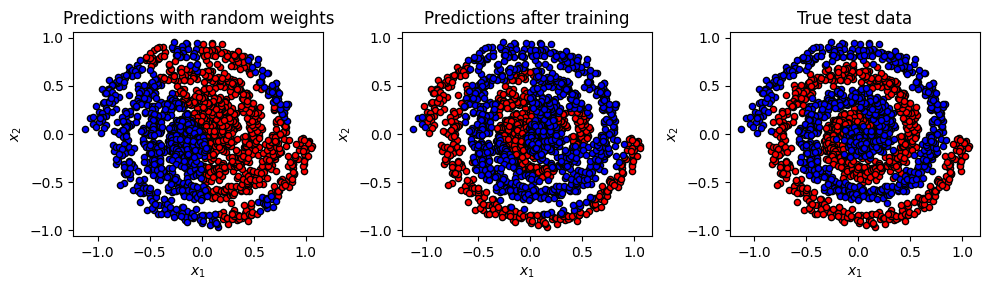

Epoch: 12 | Loss: 0.196598 | Train accuracy: 0.690000 | Test accuracy: 0.657500


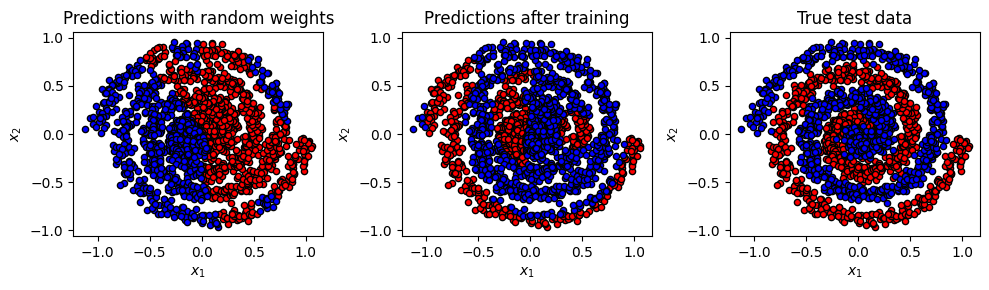

Epoch: 13 | Loss: 0.175182 | Train accuracy: 0.720000 | Test accuracy: 0.703500


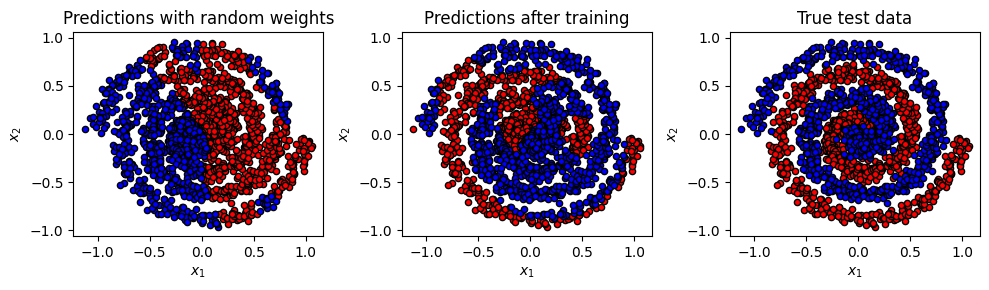

Epoch: 14 | Loss: 0.161796 | Train accuracy: 0.750000 | Test accuracy: 0.771500


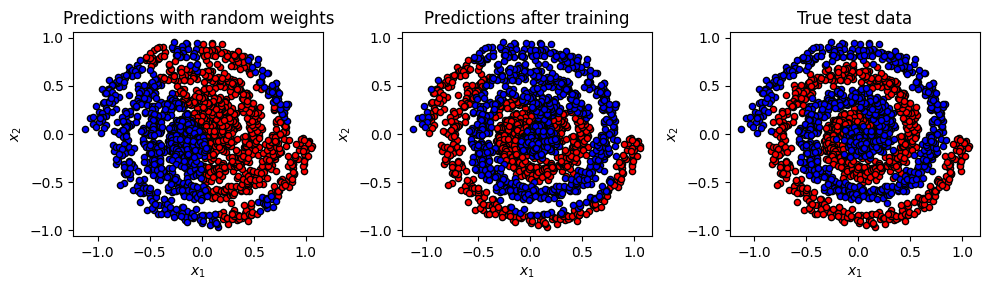

Epoch: 15 | Loss: 0.128848 | Train accuracy: 0.885000 | Test accuracy: 0.861500


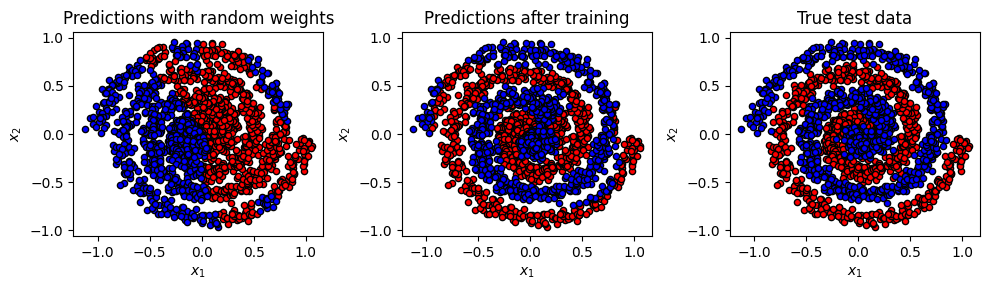

In [ ]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = spiral(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = spiral(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 15
learning_rate = 0.1
epochs = 15
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    plot_data(X_test, initial_predictions, fig, axes[0])
    plot_data(X_test, predicted_test, fig, axes[1])
    plot_data(X_test, y_test, fig, axes[2])
    axes[0].set_title("Predictions with random weights")
    axes[1].set_title("Predictions after training")
    axes[2].set_title("True test data")
    plt.tight_layout()
    plt.show()

Cost: 0.347819 | Train accuracy 0.530000 | Test Accuracy : 0.539500
Learned weights
Layer 0: [ 0.45540376  9.19473991 10.34849686]
Layer 1: [13.52753851 -4.38111636 -6.62926697]
Layer 2: [-6.21910569  1.4352685   2.48761817]
Layer 3: [ 1.07353383 -1.19816584  2.89458541]
Layer 4: [ 2.32761423 -1.07798874  1.29025963]
Layer 5: [ 1.86404463 -0.63110203  6.23028516]
Layer 6: [ 5.3236418  -1.26174777  3.73823112]
Layer 7: [ 2.01909943  2.64402795 -0.20661327]
Layer 8: [ 0.45853479 -1.06437321 -3.05741513]
Layer 9: [-3.91017706  2.03746716 -0.08122191]
Layer 10: [-4.25042992  6.47516766 -3.1042208 ]
Layer 11: [-3.70096658 -0.30524299 -0.37340465]
Layer 12: [ 1.38495533 -1.98329819  7.27733007]
Layer 13: [ 8.42955286 -3.05726292 -4.45377086]
Layer 14: [-2.83452919  4.40632619  0.03340301]


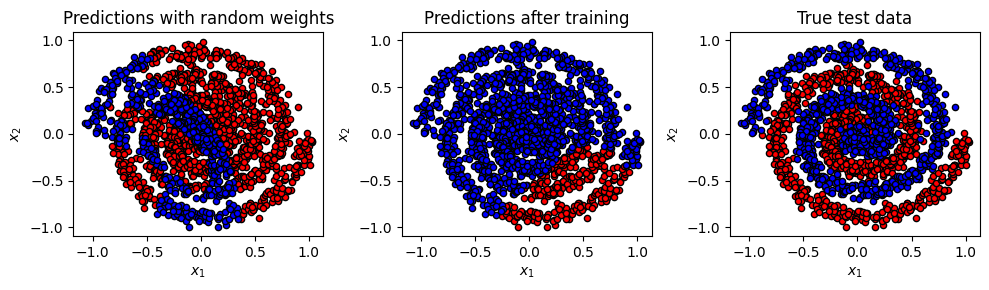

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()